# gLV Fit + Learned Output Prediction — No Cheat Knowledge

- No warm start from known true parameters (`r1`, `A1`)
- No hardcoded production weights (`c2`)

Instead, the output prediction coefficients are **learned from training communities** via
linear regression on (gLV-predicted AUC) → (true output). This is then applied to
held-out test communities to evaluate generalization.

**Structure**
1. Config & file paths
2. Load data
3. gLV helpers (simulator, residuals, optimizer) — cold-started
4. **Small dataset (11 communities)**
   - 4a. Fit A: single gLV to `test5sp_v1.csv`
   - 4b. Fit B: single gLV to `simulated_abundance_hard_switch.csv`
   - 4c. Learn output coefficients from training split
   - 4d. Evaluate on test split
   - 4e. Supplementary: full-data gLV fit
5. **Large dataset (1000 communities)** — same pipeline
   - 5a. Load large timeseries + output summary
   - 5b. Train/test split (80/20)
   - 5c. Fit gLV on training set
   - 5d. Learn output coefficients from training communities
   - 5e. Evaluate on test communities
   - 5f. Supplementary: full-data gLV fit
6. Save outputs

We do **two distinct evaluations**:

## 1) gLV model fit (time-series fidelity)
We fit gLV parameters `(r_hat, A_hat)` to *measured abundance time-series* and evaluate fit quality using
errors/residuals on the abundance trajectories (e.g., SSE / RMSE on `x(t)`).

- **Data:** measured abundance `x_obs(t)`
- **Model prediction:** `x_glv(t; r_hat, A_hat)`
- **Fit metric (model fit):** discrepancy between `x_obs(t)` and `x_glv(t; r_hat, A_hat)`

## 2) Output prediction via AUC (downstream task)
We then predict a scalar output (e.g., metabolite / phenotype) from **AUC features** computed from abundance.

### Definitions (used consistently throughout)
- `AUC_obs`  = AUC computed from **observed** abundance time-series `x_obs(t)`
- `AUC_glv`  = AUC computed from **gLV-simulated** abundance `x_glv(t; r_hat, A_hat)`
- `y_true`   = measured output target for each community
- `y_pred`   = predicted output

### Learning step (train communities only)
We learn a linear map on training communities:
`y_true ≈ W * AUC_glv + b`
(i.e., regression from gLV-derived AUC features to the true outputs)

### Evaluation step (test communities)
On held-out communities we report:
- **AUC fidelity:** how close `AUC_glv` is to `AUC_obs` (if we choose to assess this)
- **Output generalization:** how close `y_pred = W * AUC_glv + b` is to `y_true`

> Key point: gLV fit metrics are about matching **trajectories** `x(t)`.  
> Output metrics are about predicting **y** from **AUC_glv** using a learned mapping.

---
> **Why no warm start?**  
> In a real experiment you would not know the true gLV parameters. Cold-starting from
> a small diagonal (`r=0, A=diag(-0.1)`) tests whether the optimizer can recover a
> reasonable solution from data alone.
>
> **Why learned coefficients?**  
> In a real experiment you would not know which species produce the metabolite of interest
> or how much. We estimate the linear map AUC → output from training communities,
> then validate on unseen communities.

## 0. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, List, Optional
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

## 1. Config & File Paths

Edit paths here if your repo layout differs. `find_file` searches upward from cwd.

In [5]:
@dataclass
class Config:
    # ── Small dataset paths ──────────────────────────────────────────
    test_csv_rel:     str = "Test_code/Simulation/test_data/test5sp_v1.csv"
    switch_csv_rel:   str = "Test_code/gen_data/simulated_abundance_hard_switch.csv"
    prod_summary_rel: str = "Test_code/gen_data/production_auc_output_summary.csv"

    # ── Large dataset paths ───────────────────────────────────────────
    # These files are produced by running the generation pipeline:
    #   Step 1: gen_data.ipynb — generates initial conditions for 1000 communities
    #           using generate_community_dataframe() with a large size_counts,
    #           then calls simulate_gLV_dataframe() → saves to a timeseries CSV.
    #   Step 2: regime_switch_data_plot.ipynb (Cell 3) — takes that timeseries,
    #           applies the hard-switch simulation, saves:
    #             OUT_SIM_ABUND    → timeseries CSV  (Comm_name, Time, sp1..sp5)
    #             OUT_PROD_SUMMARY → summary CSV     (Comm_name, t_switch, output, AUC_sp1, ...)
    # Update the two paths below to match whatever filenames were used when generating.
    large_ts_rel:      str = "Test_code/gen_data/simulated_abundance_1000com.csv"
    large_summary_rel: str = "Test_code/gen_data/production_auc_output_summary_1000com.csv"

    # ── Column names ─────────────────────────────────────────────────
    comm_col:       str = "Comm_name"
    time_col:       str = "Time"
    species_prefix: str = "sp"

    # ── ODE solver ───────────────────────────────────────────────────
    method: str   = "RK45"
    rtol:   float = 1e-6
    atol:   float = 1e-8

    # ── Optimizer ────────────────────────────────────────────────────
    # NOTE: warm_start is intentionally False — no cheat knowledge.
    lam_A:    float = 1e-4
    max_nfev: int   = 5000
    bounds_r: Tuple[float, float] = (-5.0, 5.0)
    bounds_A: Tuple[float, float] = (-5.0, 5.0)

    # ── Train/test split ─────────────────────────────────────────────
    train_frac: float = 0.8   # 80% train, 20% test
    split_seed: int   = 42

    # ── Ridge regression (output coefficient fitting) ─────────────────
    ridge_alpha: float = 1e-3


cfg = Config()


def find_file(start: Path, rel: str) -> Path:
    p = start / rel
    if p.exists():
        return p
    target = Path(rel).name
    hits = sorted(start.rglob(target), key=lambda x: len(str(x)))
    if not hits:
        raise FileNotFoundError(f"Could not find {target!r} under {start.resolve()}")
    return hits[0]


repo_root  = Path.cwd()
test_csv   = find_file(repo_root, cfg.test_csv_rel)
switch_csv = find_file(repo_root, cfg.switch_csv_rel)
prod_csv   = find_file(repo_root, cfg.prod_summary_rel)

print("test_csv:   ", test_csv)
print("switch_csv: ", switch_csv)
print("prod_csv:   ", prod_csv)

test_csv:    /Users/batata/Desktop/BME590_Project/Test_code/Simulation/test_data/test5sp_v1.csv
switch_csv:  /Users/batata/Desktop/BME590_Project/Test_code/gen_data/simulated_abundance_hard_switch.csv
prod_csv:    /Users/batata/Desktop/BME590_Project/Test_code/gen_data/production_auc_output_summary.csv


## 2. Core Helpers

All helpers are dataset-agnostic and reused across small and large experiments.
No true parameters are referenced anywhere here.

In [4]:
# ── Data loading ──────────────────────────────────────────────────────────────

def load_timeseries(path: Path, comm_col: str, time_col: str, species_prefix: str):
    """Load a community time-series CSV.
    Returns (df, comms, timepoints, X_obs [K,T,S], x0 [K,S], species_cols).
    """
    df = pd.read_csv(path)
    species_cols = sorted(
        [c for c in df.columns if c.lower().startswith(species_prefix)],
        key=lambda x: int(x[len(species_prefix):]) if x[len(species_prefix):].isdigit() else x
    )
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    for c in species_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=[comm_col, time_col] + species_cols)
    df = df.sort_values([comm_col, time_col]).reset_index(drop=True)

    comms      = df[comm_col].astype(str).unique().tolist()
    timepoints = np.sort(df[time_col].unique().astype(float))

    X_obs, x0 = [], []
    for comm in comms:
        d = df[df[comm_col].astype(str) == comm].sort_values(time_col)
        X_obs.append(d[species_cols].to_numpy(float))
        x0.append(d[species_cols].to_numpy(float)[0])

    return df, comms, timepoints, np.stack(X_obs), np.stack(x0), species_cols


# ── Train / test split ────────────────────────────────────────────────────────

def community_split(comms: List[str], train_frac: float, seed: int):
    """Randomly split community list into train and test sets."""
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(comms))
    n_train = int(np.floor(train_frac * len(comms)))
    train_comms = [comms[i] for i in idx[:n_train]]
    test_comms  = [comms[i] for i in idx[n_train:]]
    return train_comms, test_comms


def subset_data(comms_subset, comms_all, X_obs, x0_arr):
    """Extract (X_obs, x0) arrays for a subset of communities."""
    idx = [comms_all.index(c) for c in comms_subset]
    return X_obs[idx], x0_arr[idx]


# ── gLV simulator ────────────────────────────────────────────────────────────

def simulate_glv(x0, t_eval, r, A, method=cfg.method, rtol=cfg.rtol, atol=cfg.atol):
    """Simulate gLV from x0 on t_eval. Returns (T, S) array."""
    x0     = np.maximum(x0, 0.0)
    t_eval = np.asarray(t_eval, float)
    if t_eval.size == 1:
        return x0.reshape(1, -1)
    sol = solve_ivp(
        fun=lambda t, x: np.maximum(x, 0) * (r + A @ np.maximum(x, 0)),
        t_span=(t_eval[0], t_eval[-1]),
        y0=x0,
        t_eval=t_eval,
        method=method,
        rtol=rtol,
        atol=atol,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return np.maximum(sol.y.T, 0.0)


# ── AUC ───────────────────────────────────────────────────────────────────────

def auc_trapz(X, t):
    """Per-species trapezoidal AUC. X: (T,S), t: (T,). Returns (S,)."""
    dt = np.diff(t)
    return np.sum(0.5 * (X[:-1] + X[1:]) * dt[:, None], axis=0)


# ── Parameter packing ────────────────────────────────────────────────────────

def pack(r, A):
    return np.concatenate([np.asarray(r).ravel(), np.asarray(A).ravel()])

def unpack(theta, S):
    return theta[:S], theta[S:].reshape(S, S)


# ── Cold initialisation (no cheat) ───────────────────────────────────────────

def cold_init(S):
    """Cold start: r=0, A=diag(-0.1). No prior knowledge used."""
    A0 = np.zeros((S, S))
    np.fill_diagonal(A0, -0.1)
    return pack(np.zeros(S), A0)


# ── Residual factory ─────────────────────────────────────────────────────────

def make_residuals(X_obs_data, x0_data, timepoints_data, species_cols, lam_A=cfg.lam_A):
    """Returns a residuals(theta) function for the given dataset.
    Residuals are scaled by per-species std. L2 regularization on A appended.
    """
    K_d, T_d, S_d = X_obs_data.shape
    scale = np.maximum(X_obs_data.reshape(-1, S_d).std(axis=0), 1e-6)
    print(f"  scale: {dict(zip(species_cols, scale.round(4)))}")

    def residuals(theta):
        r, A = unpack(theta, S_d)
        errs = []
        try:
            for k in range(K_d):
                Xp = simulate_glv(x0_data[k], timepoints_data, r, A)
                errs.append(((Xp - X_obs_data[k]) / scale).ravel())
        except Exception:
            n_base = K_d * T_d * S_d
            return np.concatenate([np.full(n_base, 1e2), np.full(S_d ** 2, 1e2)])
        base = np.concatenate(errs)
        reg  = np.sqrt(lam_A) * A.ravel()
        return np.concatenate([base, reg])

    return residuals


# ── gLV optimizer ────────────────────────────────────────────────────────────

def fit_glv(residuals_fn, theta0, S, label=""):
    lb = np.concatenate([np.full(S, cfg.bounds_r[0]), np.full(S**2, cfg.bounds_A[0])])
    ub = np.concatenate([np.full(S, cfg.bounds_r[1]), np.full(S**2, cfg.bounds_A[1])])

    print(f"\n[{label}] initial residual norm: {np.linalg.norm(residuals_fn(theta0)):.4f}")

    result = least_squares(
        fun=residuals_fn,
        x0=theta0,
        bounds=(lb, ub),
        method="trf",
        loss="linear",
        max_nfev=cfg.max_nfev,
        ftol=1e-10, xtol=1e-10, gtol=1e-10,
        verbose=1,
    )

    r_hat, A_hat = unpack(result.x, S)
    print(f"[{label}] converged={result.success} | cost={result.cost:.4g} | nfev={result.nfev}")
    return r_hat, A_hat, result


# ── Compute AUC matrix for a set of communities ───────────────────────────────

def compute_auc_matrix(comms_list, x0_data, X_obs_data, timepoints_data, r_hat, A_hat):
    """Simulate gLV and return (K, S) AUC matrix and (K, T, S) predicted trajectories."""
    K = len(comms_list)
    X_pred = np.stack([
        simulate_glv(x0_data[k], timepoints_data, r_hat, A_hat)
        for k in range(K)
    ])
    AUC = np.stack([auc_trapz(X_pred[k], timepoints_data) for k in range(K)])
    return AUC, X_pred


# ── Fit output coefficients (Ridge regression, no intercept) ──────────────────

def fit_output_coefficients(AUC_train, output_true_train, alpha=cfg.ridge_alpha):
    """Fit beta: output ~ AUC @ beta using Ridge regression.
    AUC_train: (K_train, S), output_true_train: (K_train,)
    Returns fitted Ridge model and beta coefficients (S,).
    """
    model = Ridge(alpha=alpha, fit_intercept=True)
    model.fit(AUC_train, output_true_train)
    return model, model.coef_


# ── Predict output and evaluate ───────────────────────────────────────────────

def predict_and_evaluate(comms_list, AUC, model, gt_df, comm_col, species_cols, label):
    """Apply learned coefficients to AUC, compare to ground truth.
    Returns eval_df with output_pred, output_true, errors.
    """
    output_pred = model.predict(AUC)

    pred_df = pd.DataFrame({comm_col: comms_list})
    for i, sp in enumerate(species_cols):
        pred_df[f"AUC_{sp}_pred"] = AUC[:, i]
    pred_df["output_pred"] = output_pred

    eval_df = pred_df.merge(
        gt_df[[comm_col, "output"]].rename(columns={"output": "output_true"}),
        on=comm_col
    )
    eval_df["abs_err"] = (eval_df["output_pred"] - eval_df["output_true"]).abs()
    eval_df["rel_err"] = eval_df["abs_err"] / (eval_df["output_true"].abs() + 1e-12)

    r2   = r2_score(eval_df["output_true"], eval_df["output_pred"])
    corr = np.corrcoef(eval_df["output_true"], eval_df["output_pred"])[0, 1]

    print(f"\n=== {label} ===")
    print(f"  R²:           {r2:.4f}")
    print(f"  Pearson corr: {corr:.4f}")
    print(f"  Mean rel err: {eval_df['rel_err'].mean():.4f}")

    return eval_df


# ── Trajectory error summary ──────────────────────────────────────────────────

def trajectory_error_summary(X_obs_d, X_pred_d, comms_d, timepoints_d, species_cols, label, out_dir):
    K_d, T_d, S_d = X_obs_d.shape
    scale = np.maximum(X_obs_d.reshape(-1, S_d).std(axis=0), 1e-6)

    rows = []
    for k, comm in enumerate(comms_d):
        obs  = X_obs_d[k]
        pred = X_pred_d[k]
        rmse_comm   = np.sqrt(np.mean(((pred - obs) / scale) ** 2))
        r2_comm     = r2_score(obs.ravel(), pred.ravel())
        rmse_per_sp = np.sqrt(np.mean(((pred - obs) / scale) ** 2, axis=0))
        row = {"Comm_name": comm, "RMSE_norm": rmse_comm, "R2": r2_comm}
        for i, sp in enumerate(species_cols):
            row[f"RMSE_{sp}"] = rmse_per_sp[i]
        rows.append(row)

    summary_df = pd.DataFrame(rows).sort_values("RMSE_norm").reset_index(drop=True)
    print(f"\n{'='*50}")
    print(f"  Trajectory error — {label}")
    print(f"  Mean RMSE: {summary_df['RMSE_norm'].mean():.4f}  |  Mean R²: {summary_df['R2'].mean():.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"Trajectory fit error — {label}")

    axes[0].bar(summary_df["Comm_name"], summary_df["RMSE_norm"], color="steelblue", edgecolor="k", linewidth=0.6)
    axes[0].axhline(summary_df["RMSE_norm"].mean(), color="red", linestyle="--", linewidth=1.2,
                    label=f"mean={summary_df['RMSE_norm'].mean():.3f}")
    axes[0].set_title("Normalized RMSE per community")
    axes[0].set_xlabel("Community"); axes[0].set_ylabel("RMSE")
    axes[0].tick_params(axis="x", rotation=45); axes[0].legend()

    sp_rmse_mean = summary_df[[f"RMSE_{sp}" for sp in species_cols]].mean()
    axes[1].bar(species_cols, sp_rmse_mean.values, color="darkorange", edgecolor="k", linewidth=0.6)
    axes[1].set_title("Normalized RMSE per species (avg across communities)")
    axes[1].set_xlabel("Species"); axes[1].set_ylabel("RMSE")

    plt.tight_layout()
    out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / f"traj_error_{label.replace(' ','_').replace(':','')}.png", dpi=150, bbox_inches="tight")
    plt.show()

    summary_df.to_csv(out_dir / f"traj_error_{label.replace(' ','_').replace(':','')}.csv", index=False)
    return summary_df


# ── Scatter: true vs predicted output ────────────────────────────────────────

def plot_output_scatter(eval_df, label, ax=None):
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(5, 5))
    lo = min(eval_df["output_true"].min(), eval_df["output_pred"].min())
    hi = max(eval_df["output_true"].max(), eval_df["output_pred"].max())
    ax.scatter(eval_df["output_true"], eval_df["output_pred"], zorder=3)
    ax.plot([lo, hi], [lo, hi], "k--", linewidth=1, label="y = x")
    r2   = r2_score(eval_df["output_true"], eval_df["output_pred"])
    corr = np.corrcoef(eval_df["output_true"], eval_df["output_pred"])[0, 1]
    ax.set_title(f"{label}\nR²={r2:.3f}  Corr={corr:.3f}")
    ax.set_xlabel("output_true"); ax.set_ylabel("output_pred")
    ax.legend()
    if standalone:
        plt.tight_layout(); plt.show()


# ── Trajectory plot (best / median / worst) ───────────────────────────────────

def plot_trajectories(X_obs_data, X_pred_data, comms_data, timepoints_data, species_cols, label):
    scale = np.maximum(X_obs_data.reshape(-1, X_obs_data.shape[-1]).std(axis=0), 1e-6)
    rmse  = np.sqrt(np.mean(((X_pred_data - X_obs_data) / scale) ** 2, axis=(1, 2)))
    order = np.argsort(rmse)
    picks = [order[0], order[len(order) // 2], order[-1]]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
    fig.suptitle(f"{label} — best / median / worst trajectory fit")

    for ax, k in zip(axes, picks):
        for i, sp in enumerate(species_cols):
            c = f"C{i}"
            ax.plot(timepoints_data, X_obs_data[k, :, i],  color=c, linewidth=1.5, label=f"{sp} obs")
            ax.plot(timepoints_data, X_pred_data[k, :, i], color=c, linewidth=1.5,
                    linestyle="--", label=f"{sp} pred")
        ax.set_title(f"{comms_data[k]}  (RMSE={rmse[k]:.3f})")
        ax.set_xlabel("Time"); ax.set_ylabel("Abundance")
    axes[0].legend(ncol=2, fontsize=7)
    plt.tight_layout(); plt.show()


print("All helpers defined.")

All helpers defined.


---
## 3. Load Small Dataset (11 communities)

In [61]:
_, comms_sm, tp_sm, X_sm, x0_sm, sp_cols_sm = load_timeseries(
    test_csv, cfg.comm_col, cfg.time_col, cfg.species_prefix)

_, comms_sw, tp_sw, X_sw, x0_sw, _ = load_timeseries(
    switch_csv, cfg.comm_col, cfg.time_col, cfg.species_prefix)

gt_sm = pd.read_csv(prod_csv)
gt_sm[cfg.comm_col] = gt_sm[cfg.comm_col].astype(str)

K_sm, T_sm, S_sm = X_sm.shape
print(f"test5sp:     K={K_sm}, T={T_sm}, S={S_sm}")
print(f"hard-switch: K={len(comms_sw)}, T={len(tp_sw)}, S={S_sm}")
print(f"communities: {comms_sm}")
print(f"time range:  {tp_sm[0]} – {tp_sm[-1]}")

test5sp:     K=11, T=21, S=5
hard-switch: K=11, T=21, S=5
communities: ['comm1', 'comm10', 'comm11', 'comm2', 'comm3', 'comm4', 'comm5', 'comm6', 'comm7', 'comm8', 'comm9']
time range:  0.0 – 20.0


### 3a. Train / Test Split (small dataset)

With only 11 communities the split is small, but the logic mirrors what we do at scale.
The split is applied to **both** trajectory datasets (they share the same community names).

In [62]:
train_comms_sm, test_comms_sm = community_split(comms_sm, cfg.train_frac, cfg.split_seed)

print(f"Train ({len(train_comms_sm)}): {train_comms_sm}")
print(f"Test  ({len(test_comms_sm)}):  {test_comms_sm}")

# Subset arrays
X_sm_tr, x0_sm_tr = subset_data(train_comms_sm, comms_sm, X_sm, x0_sm)
X_sm_te, x0_sm_te = subset_data(test_comms_sm,  comms_sm, X_sm, x0_sm)

X_sw_tr, x0_sw_tr = subset_data(train_comms_sm, comms_sw, X_sw, x0_sw)
X_sw_te, x0_sw_te = subset_data(test_comms_sm,  comms_sw, X_sw, x0_sw)

Train (8): ['comm5', 'comm6', 'comm1', 'comm9', 'comm2', 'comm4', 'comm11', 'comm3']
Test  (3):  ['comm8', 'comm10', 'comm7']


---
## 4. Fit A — Single gLV to `test5sp_v1.csv` (cold start)

In [63]:
theta0_sm = cold_init(S_sm)

print("Building residuals for test5sp TRAINING communities...")
res_fn_A = make_residuals(X_sm_tr, x0_sm_tr, tp_sm, sp_cols_sm)
r_hat_A, A_hat_A, opt_A = fit_glv(res_fn_A, theta0_sm, S_sm, label="Fit A: test5sp (train)")

Building residuals for test5sp TRAINING communities...
  scale: {'sp1': np.float64(0.0698), 'sp2': np.float64(0.0666), 'sp3': np.float64(0.5098), 'sp4': np.float64(0.1104), 'sp5': np.float64(0.3196)}

[Fit A: test5sp (train)] initial residual norm: 32.1161


`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 5.1572e+02, final cost 1.1671e-03, first-order optimality 5.58e-09.
[Fit A: test5sp (train)] converged=True | cost=0.001167 | nfev=16


In [64]:
print("r_hat (Fit A):")
print(pd.Series(r_hat_A, index=sp_cols_sm).round(4))
print("\nA_hat (Fit A):")
print(pd.DataFrame(A_hat_A, index=sp_cols_sm, columns=sp_cols_sm).round(4))

r_hat (Fit A):
sp1    0.4000
sp2    0.5161
sp3    1.3440
sp4    0.7970
sp5    1.1601
dtype: float64

A_hat (Fit A):
        sp1     sp2     sp3     sp4     sp5
sp1 -1.8808 -0.3182  0.0000 -0.1583 -0.0000
sp2  0.0484 -2.3151  0.0000 -0.3355 -0.0000
sp3 -0.0000  0.0000 -1.0869 -0.0000  0.1689
sp4 -1.1037  0.4139 -0.0000 -2.7859  0.0000
sp5  0.0000 -0.0000  0.5370  0.0000 -1.8850


### 4a. Trajectory quality on training set (Fit A)


  Trajectory error — Fit_A_train
  Mean RMSE: 0.0000  |  Mean R²: 1.0000


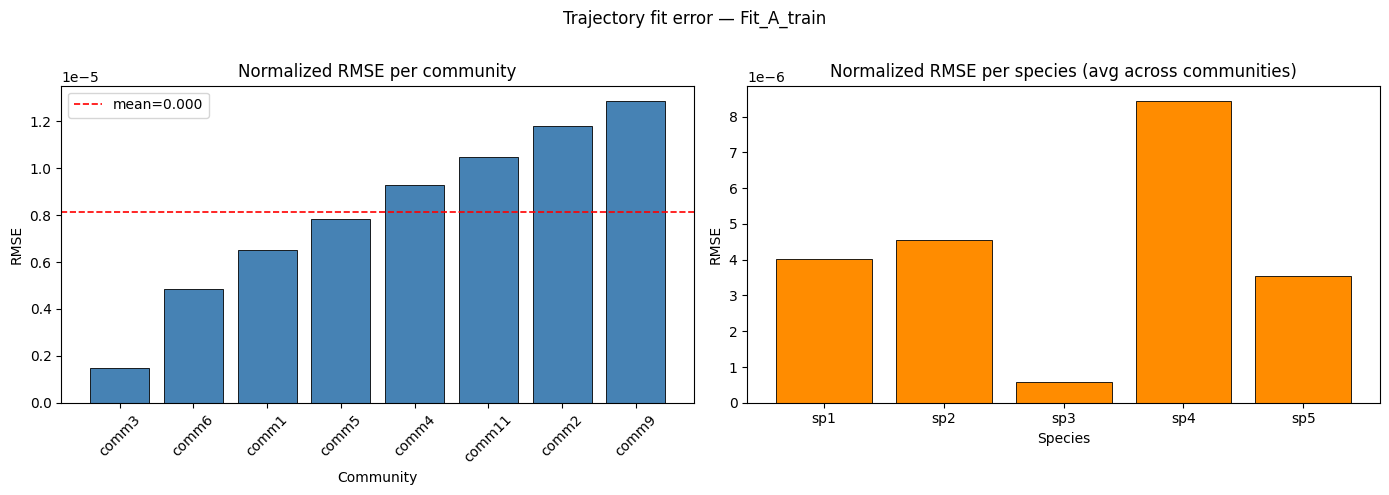

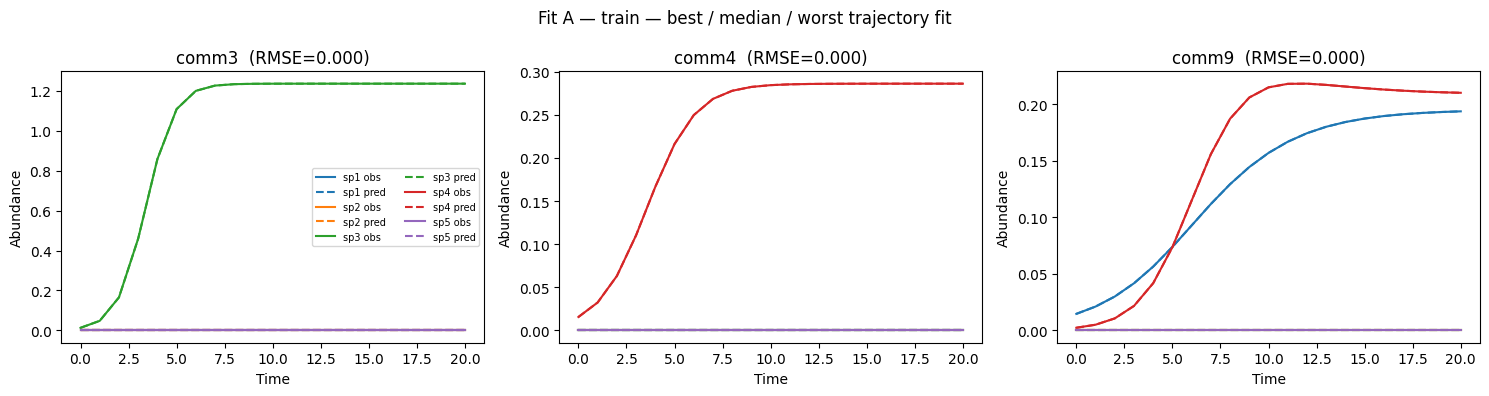

In [65]:
AUC_A_tr, Xpred_A_tr = compute_auc_matrix(train_comms_sm, x0_sm_tr, X_sm_tr, tp_sm, r_hat_A, A_hat_A)
out_dir_sm = Path("glv_learned_outputs/small")
_ = trajectory_error_summary(X_sm_tr, Xpred_A_tr, train_comms_sm, tp_sm, sp_cols_sm, "Fit_A_train", out_dir_sm)
plot_trajectories(X_sm_tr, Xpred_A_tr, train_comms_sm, tp_sm, sp_cols_sm, "Fit A — train")

### 4b. Learn output coefficients from training communities (Fit A)

We regress `output_true` onto the gLV-predicted per-species AUC for training communities.
This estimates the mapping AUC → output without assuming knowledge of c2.

In [66]:
# Get ground-truth outputs for training communities
gt_tr_A = (
    gt_sm[gt_sm[cfg.comm_col].isin(train_comms_sm)]
    .set_index(cfg.comm_col)
    .loc[train_comms_sm, "output"]
    .values
)

model_A, beta_A = fit_output_coefficients(AUC_A_tr, gt_tr_A)

print("Learned output coefficients (Fit A):")
for sp, b in zip(sp_cols_sm, beta_A):
    print(f"  {sp}: {b:.4f}")
print(f"  intercept: {model_A.intercept_:.4f}")

Learned output coefficients (Fit A):
  sp1: -0.1308
  sp2: -0.7051
  sp3: -0.0621
  sp4: -0.4289
  sp5: 0.5453
  intercept: 3.2682


### 4c. Evaluate on TEST communities (Fit A)


=== Fit A — test5sp — TEST communities ===
  R²:           0.8783
  Pearson corr: 0.9995
  Mean rel err: 0.0603


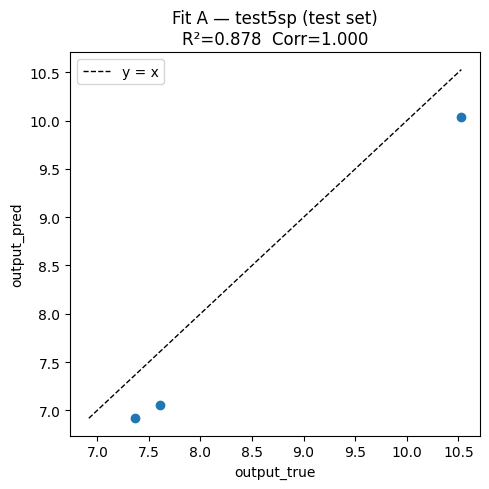

,Comm_name,AUC_sp1_pred,AUC_sp2_pred,AUC_sp3_pred,AUC_sp4_pred,AUC_sp5_pred,output_pred,output_true,abs_err,rel_err
0,comm8,0.00000,0.0,0.000000,4.029522,10.104930,7.050095,7.605660,0.555565,0.073046
2,comm7,0.00000,0.0,0.000000,4.616480,10.322985,6.917271,7.366726,0.449455,0.061011
1,comm10,3.01317,0.0,22.015122,0.000000,15.637805,10.035093,10.529616,0.494524,0.046965


In [67]:
AUC_A_te, Xpred_A_te = compute_auc_matrix(test_comms_sm, x0_sm_te, X_sm_te, tp_sm, r_hat_A, A_hat_A)

eval_A_te = predict_and_evaluate(
    test_comms_sm, AUC_A_te, model_A, gt_sm, cfg.comm_col, sp_cols_sm,
    label="Fit A — test5sp — TEST communities"
)
plot_output_scatter(eval_A_te, "Fit A — test5sp (test set)")
eval_A_te.sort_values("rel_err", ascending=False)

---
## 5. Fit B — Single gLV to `simulated_abundance_hard_switch.csv` (cold start)

In [68]:
print("Building residuals for hard-switch TRAINING communities...")
res_fn_B = make_residuals(X_sw_tr, x0_sw_tr, tp_sw, sp_cols_sm)
r_hat_B, A_hat_B, opt_B = fit_glv(res_fn_B, theta0_sm, S_sm, label="Fit B: hard-switch (train)")

Building residuals for hard-switch TRAINING communities...
  scale: {'sp1': np.float64(0.0481), 'sp2': np.float64(0.0409), 'sp3': np.float64(0.2176), 'sp4': np.float64(0.0904), 'sp5': np.float64(0.1845)}

[Fit B: hard-switch (train)] initial residual norm: 31.3501
`ftol` termination condition is satisfied.
Function evaluations 36, initial cost 4.9141e+02, final cost 5.2718e+01, first-order optimality 3.12e-04.
[Fit B: hard-switch (train)] converged=True | cost=52.72 | nfev=36


In [69]:
print("r_hat (Fit B):")
print(pd.Series(r_hat_B, index=sp_cols_sm).round(4))
print("\nA_hat (Fit B):")
print(pd.DataFrame(A_hat_B, index=sp_cols_sm, columns=sp_cols_sm).round(4))

r_hat (Fit B):
sp1    0.5074
sp2    0.6510
sp3    1.6023
sp4    0.9955
sp5    1.3537
dtype: float64

A_hat (Fit B):
        sp1     sp2     sp3     sp4     sp5
sp1 -3.4627 -1.1957  0.0000 -1.0749  0.0000
sp2 -5.0000 -4.9383  0.0000  0.0741  0.0000
sp3 -0.0000 -0.0000 -3.3802  0.0000 -0.1180
sp4 -4.2626 -1.6267 -0.0000 -3.8683 -0.0000
sp5  0.0000  0.0000 -1.5249  0.0000 -2.3484


### 5a. Trajectory quality on training set (Fit B)


  Trajectory error — Fit_B_train
  Mean RMSE: 0.3324  |  Mean R²: 0.8736


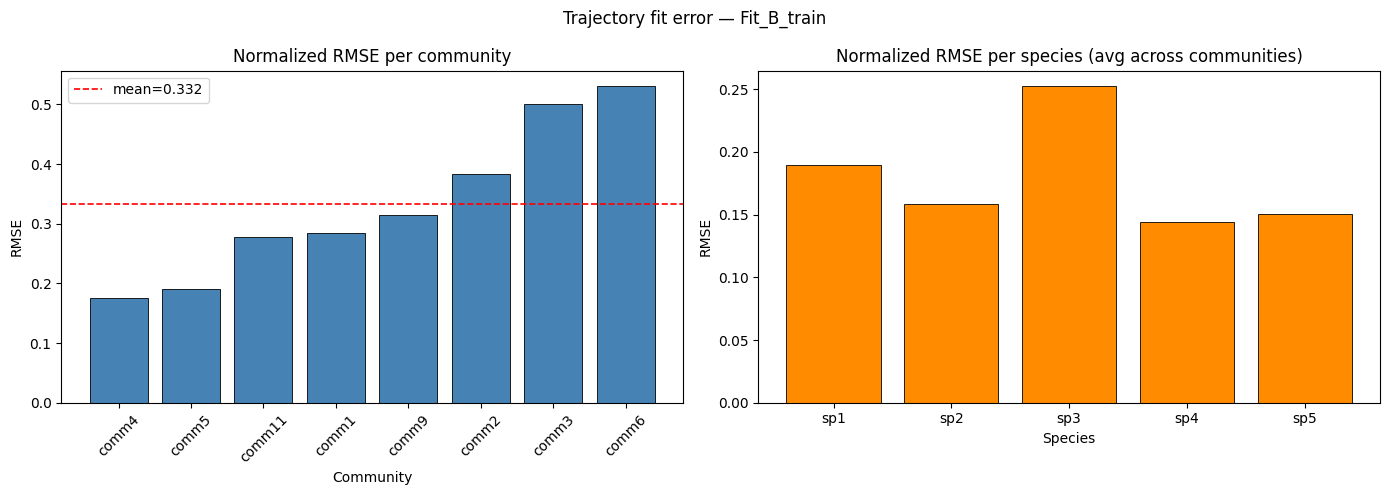

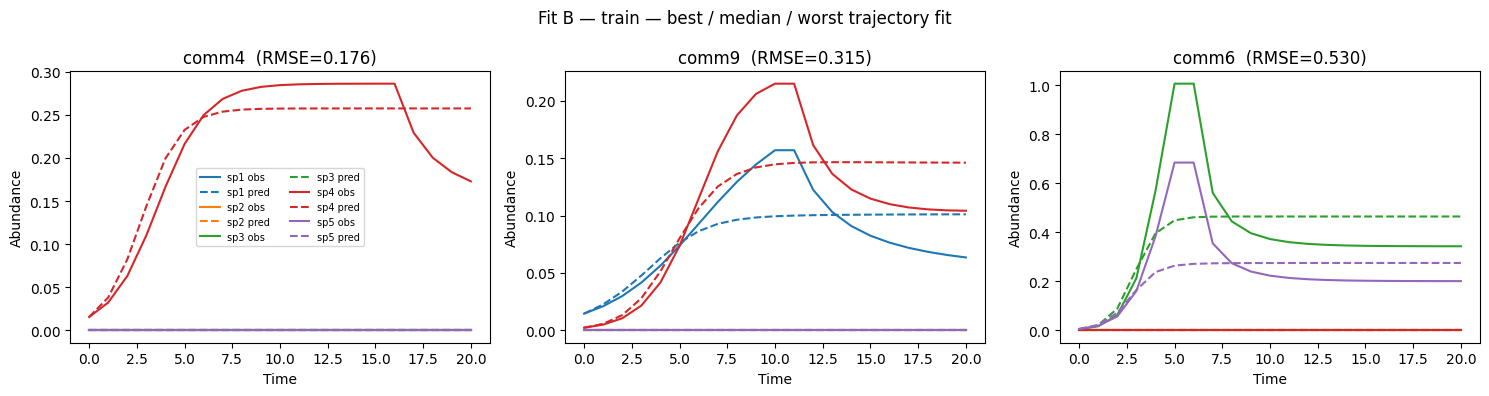

In [70]:
AUC_B_tr, Xpred_B_tr = compute_auc_matrix(train_comms_sm, x0_sw_tr, X_sw_tr, tp_sw, r_hat_B, A_hat_B)
_ = trajectory_error_summary(X_sw_tr, Xpred_B_tr, train_comms_sm, tp_sw, sp_cols_sm, "Fit_B_train", out_dir_sm)
plot_trajectories(X_sw_tr, Xpred_B_tr, train_comms_sm, tp_sw, sp_cols_sm, "Fit B — train")

### 5b. Learn output coefficients from training communities (Fit B)

In [71]:
gt_tr_B = (
    gt_sm[gt_sm[cfg.comm_col].isin(train_comms_sm)]
    .set_index(cfg.comm_col)
    .loc[train_comms_sm, "output"]
    .values
)

model_B, beta_B = fit_output_coefficients(AUC_B_tr, gt_tr_B)

print("Learned output coefficients (Fit B):")
for sp, b in zip(sp_cols_sm, beta_B):
    print(f"  {sp}: {b:.4f}")
print(f"  intercept: {model_B.intercept_:.4f}")

Learned output coefficients (Fit B):
  sp1: 0.9534
  sp2: 0.0401
  sp3: 0.4364
  sp4: 0.0227
  sp5: 1.2121
  intercept: -0.1358


### 5c. Evaluate on TEST communities (Fit B)


=== Fit B — hard-switch — TEST communities ===
  R²:           -5.4328
  Pearson corr: -0.9873
  Mean rel err: 0.4141


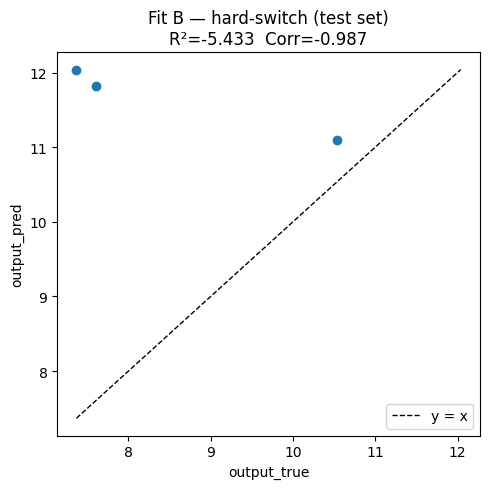

,Comm_name,AUC_sp1_pred,AUC_sp2_pred,AUC_sp3_pred,AUC_sp4_pred,AUC_sp5_pred,output_pred,output_true,abs_err,rel_err
2,comm7,0.000000,0.0,0.000000,4.378085,9.962691,12.039719,7.366726,4.672993,0.634338
0,comm8,0.000000,0.0,0.000000,3.955698,9.787816,11.818148,7.605660,4.212487,0.553862
1,comm10,2.363177,0.0,7.992539,0.000000,4.531992,11.098764,10.529616,0.569148,0.054052


In [72]:
AUC_B_te, Xpred_B_te = compute_auc_matrix(test_comms_sm, x0_sw_te, X_sw_te, tp_sw, r_hat_B, A_hat_B)

eval_B_te = predict_and_evaluate(
    test_comms_sm, AUC_B_te, model_B, gt_sm, cfg.comm_col, sp_cols_sm,
    label="Fit B — hard-switch — TEST communities"
)
plot_output_scatter(eval_B_te, "Fit B — hard-switch (test set)")
eval_B_te.sort_values("rel_err", ascending=False)

### 5d. Side-by-side comparison (Fit A vs Fit B, test set)

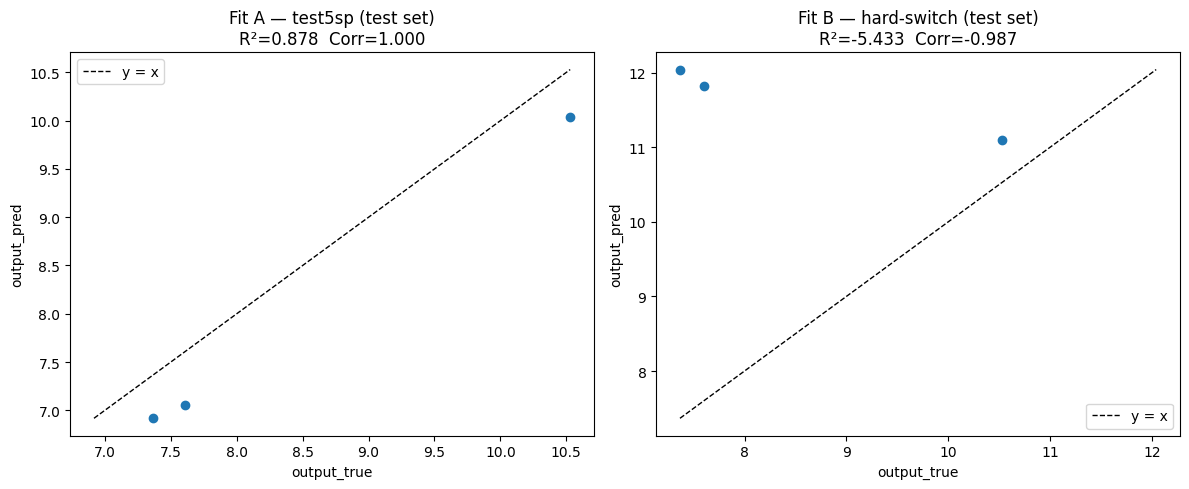

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_output_scatter(eval_A_te, "Fit A — test5sp (test set)", ax=axes[0])
plot_output_scatter(eval_B_te, "Fit B — hard-switch (test set)", ax=axes[1])
plt.tight_layout()
fig.savefig(out_dir_sm / "small_test_scatter_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 6. Supplementary — Full-data gLV Fit (small dataset)

Per project leader request: fit gLV to **all** communities (no train/test split) for supplementary slides.
This is purely descriptive — shows how well a single gLV explains all the data globally.

=== SUPPLEMENTARY: Full-data fit A (test5sp) ===
  scale: {'sp1': np.float64(0.0907), 'sp2': np.float64(0.0584), 'sp3': np.float64(0.5373), 'sp4': np.float64(0.1403), 'sp5': np.float64(0.3754)}

[Fit A FULL: test5sp] initial residual norm: 38.7160
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 16, initial cost 7.4946e+02, final cost 1.1816e-03, first-order optimality 5.62e-10.
[Fit A FULL: test5sp] converged=True | cost=0.001182 | nfev=16

  Trajectory error — Fit_A_FULL
  Mean RMSE: 0.0000  |  Mean R²: 1.0000


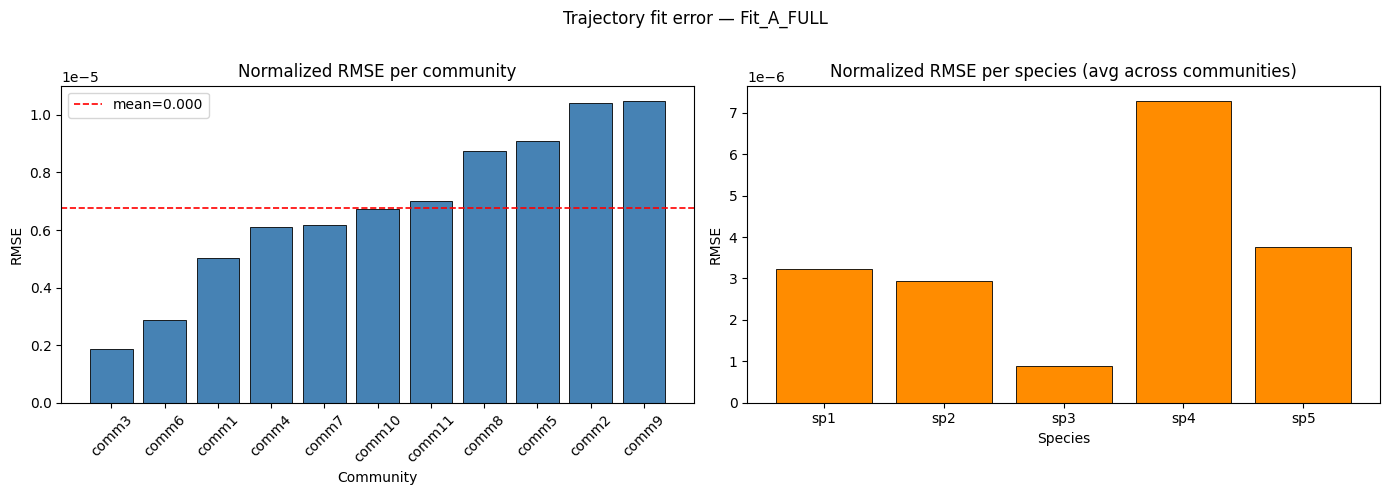

In [74]:
# Fit A full (test5sp)
print("=== SUPPLEMENTARY: Full-data fit A (test5sp) ===")
res_fn_A_full = make_residuals(X_sm, x0_sm, tp_sm, sp_cols_sm)
r_hat_A_full, A_hat_A_full, _ = fit_glv(res_fn_A_full, theta0_sm, S_sm, label="Fit A FULL: test5sp")

AUC_A_full, Xpred_A_full = compute_auc_matrix(comms_sm, x0_sm, X_sm, tp_sm, r_hat_A_full, A_hat_A_full)
_ = trajectory_error_summary(X_sm, Xpred_A_full, comms_sm, tp_sm, sp_cols_sm, "Fit_A_FULL", out_dir_sm)

=== SUPPLEMENTARY: Full-data fit B (hard-switch) ===
  scale: {'sp1': np.float64(0.0465), 'sp2': np.float64(0.0359), 'sp3': np.float64(0.2238), 'sp4': np.float64(0.1058), 'sp5': np.float64(0.2066)}

[Fit B FULL: hard-switch] initial residual norm: 37.5768
`ftol` termination condition is satisfied.
Function evaluations 48, initial cost 7.0601e+02, final cost 8.5629e+01, first-order optimality 8.48e-04.
[Fit B FULL: hard-switch] converged=True | cost=85.63 | nfev=48

  Trajectory error — Fit_B_FULL
  Mean RMSE: 0.3654  |  Mean R²: 0.8402


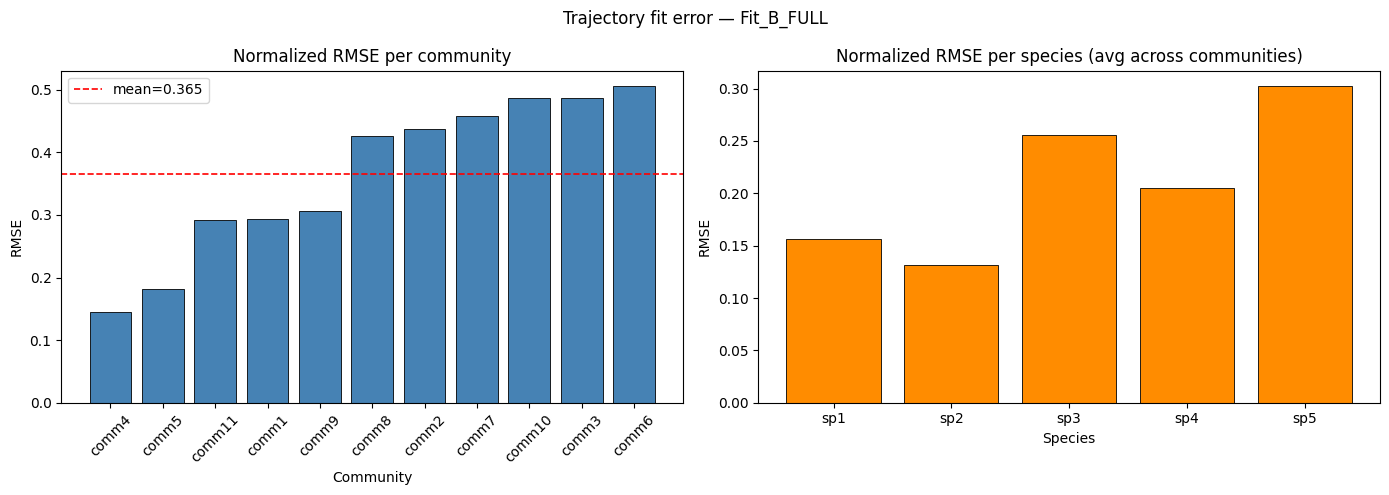

In [75]:
# Fit B full (hard-switch)
print("=== SUPPLEMENTARY: Full-data fit B (hard-switch) ===")
res_fn_B_full = make_residuals(X_sw, x0_sw, tp_sw, sp_cols_sm)
r_hat_B_full, A_hat_B_full, _ = fit_glv(res_fn_B_full, theta0_sm, S_sm, label="Fit B FULL: hard-switch")

AUC_B_full, Xpred_B_full = compute_auc_matrix(comms_sw, x0_sw, X_sw, tp_sw, r_hat_B_full, A_hat_B_full)
_ = trajectory_error_summary(X_sw, Xpred_B_full, comms_sw, tp_sw, sp_cols_sm, "Fit_B_FULL", out_dir_sm)

---
---
## 7. Large Dataset (1000 communities)

Same pipeline, but now with a proper train/test split at scale.

> **File paths:** Update `cfg.large_ts_rel` and `cfg.large_summary_rel` in Config (Section 1)
> to point to the 1000-community timeseries and output summary CSVs generated by `gen_data_1000com`.
> The expected format is identical to the small dataset:
> - Timeseries: columns `Comm_name, Time, sp1, sp2, ..., spN`
> - Summary: columns `Comm_name, output, ...`

### 7a. Load large dataset

In [76]:
import time
from datetime import timedelta

def _stamp(msg, t0):
    dt = timedelta(seconds=int(time.time() - t0))
    print(f"[{dt}] {msg}", flush=True)


t0_global = time.time()

# ------------------------------------------------------------
# DATASET PATHS
# ------------------------------------------------------------
_stamp("Resolving dataset paths...", t0_global)

large_ts_rel = (
    "gen_data_1000com/glv_positive_strong_complete/"
    "simulated_abundance_switch.csv"
)

large_summary_rel = (
    "gen_data_1000com/glv_positive_strong_complete/"
    "production_output_summary.csv"
)

large_ts_csv  = find_file(repo_root, large_ts_rel)
large_sum_csv = find_file(repo_root, large_summary_rel)

print("large_ts_csv: ", large_ts_csv)
print("large_sum_csv:", large_sum_csv)

_stamp("Paths resolved.", t0_global)


# ------------------------------------------------------------
# LOAD TIMESERIES  (THIS IS THE LONG STEP)
# ------------------------------------------------------------
_stamp("Loading large time-series dataset (entering load_timeseries)...", t0_global)

t_load = time.time()

_, comms_lg, tp_lg, X_lg, x0_lg, sp_cols_lg = load_timeseries(
    large_ts_csv,
    cfg.comm_col,
    cfg.time_col,
    cfg.species_prefix
)

_stamp(
    f"Finished load_timeseries "
    f"(elapsed {time.time() - t_load:.1f}s)",
    t0_global
)


# ------------------------------------------------------------
# LOAD SUMMARY CSV
# ------------------------------------------------------------
_stamp("Loading production summary CSV...", t0_global)

t_sum = time.time()

# dtype enforced at read time (no post-copy)
gt_lg = pd.read_csv(
    large_sum_csv,
    dtype={cfg.comm_col: str}
)

_stamp(
    f"Finished summary load "
    f"(elapsed {time.time() - t_sum:.1f}s)",
    t0_global
)


# ------------------------------------------------------------
# DATASET SUMMARY
# ------------------------------------------------------------
_stamp("Computing dataset dimensions...", t0_global)

K_lg, T_lg, S_lg = X_lg.shape

print(f"\nLarge dataset: K={K_lg}, T={T_lg}, S={S_lg}")
print(f"Time range: {tp_lg[0]} – {tp_lg[-1]}")

_stamp("Large dataset ready.", t0_global)

[0:00:00] Resolving dataset paths...
large_ts_csv:  /Users/batata/Desktop/BME590_Project/gen_data_1000com/glv_positive_strong_complete/simulated_abundance_switch.csv
large_sum_csv: /Users/batata/Desktop/BME590_Project/gen_data_1000com/glv_positive_strong_complete/production_output_summary.csv
[0:00:00] Paths resolved.
[0:00:00] Loading large time-series dataset (entering load_timeseries)...
[0:00:14] Finished load_timeseries (elapsed 14.3s)
[0:00:14] Loading production summary CSV...
[0:00:14] Finished summary load (elapsed 0.0s)
[0:00:14] Computing dataset dimensions...

Large dataset: K=1000, T=201, S=25
Time range: 0.0 – 20.0
[0:00:14] Large dataset ready.


### 7b. Train / Test Split (large dataset, 80/20)

In [78]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import time

t0 = time.time()
print("\n[Split] Creating train/test split...", flush=True)

train_comms_lg, test_comms_lg = community_split(
    comms_lg, cfg.train_frac, cfg.split_seed
)

print(f"Train: {len(train_comms_lg)} communities")
print(f"Test:  {len(test_comms_lg)} communities")

print("[Split] Encoding community IDs...", flush=True)

cat = pd.Categorical(comms_lg, categories=comms_lg, ordered=True)
comm_to_int = dict(zip(cat.categories, range(len(cat.categories))))

def build_indices(comm_subset, mapping, label):
    out = np.empty(len(comm_subset), dtype=np.int64)
    for i, c in enumerate(
        tqdm(comm_subset, desc=f"Indexing {label}", unit="comm")
    ):
        out[i] = mapping[c]
    return out

_idx_tr = build_indices(train_comms_lg, comm_to_int, "train")
_idx_te = build_indices(test_comms_lg,  comm_to_int, "test")

print("[Split] Extracting tensors...", flush=True)

X_lg_tr  = X_lg[_idx_tr]
x0_lg_tr = x0_lg[_idx_tr]

X_lg_te  = X_lg[_idx_te]
x0_lg_te = x0_lg[_idx_te]

print(f"[Split] Done ({time.time()-t0:.1f}s)", flush=True)


[Split] Creating train/test split...
Train: 800 communities
Test:  200 communities
[Split] Encoding community IDs...


Indexing train:   0%|          | 0/800 [00:00<?, ?comm/s]

Indexing test:   0%|          | 0/200 [00:00<?, ?comm/s]

[Split] Extracting tensors...
[Split] Done (0.1s)


In [80]:
# ============================================================
# SINGLE PROGRESS BAR GLV FIT
# (NO CHANGE TO MODEL OR NUMERICS)
# ============================================================

from tqdm.auto import tqdm
import numpy as np
import time
from scipy.optimize import least_squares


# ------------------------------------------------------------
# GLOBAL PROGRESS BAR STATE
# ------------------------------------------------------------
class GlobalProgress:
    def __init__(self, n_comms):
        self.n_comms = n_comms
        self.eval_count = 0
        self.bar = None
        self.start = time.time()

    def start_bar(self):
        if self.bar is None:
            self.bar = tqdm(
                total=0,
                dynamic_ncols=True,
                desc="GLV fitting",
                leave=True,
            )

    def new_eval(self):
        self.eval_count += 1
        self.bar.set_description(
            f"GLV fitting | residual eval {self.eval_count}"
        )

    def step(self):
        self.bar.update(1)

    def close(self):
        if self.bar is not None:
            self.bar.close()


# ------------------------------------------------------------
# Residual builder WITH SINGLE LIVE BAR
# ------------------------------------------------------------
def make_residuals_with_progress(
    X_obs_data,
    x0_data,
    timepoints_data,
    sp_cols,
):

    K_d = X_obs_data.shape[0]
    S_d = X_obs_data.shape[2]

    progress = GlobalProgress(K_d)
    progress.start_bar()

    # compute scaling once (unchanged math)
    scale = np.maximum(
        np.abs(X_obs_data).max(axis=(0, 1)),
        1e-8
    )

    print(f"[Residual setup] K={K_d} communities, S={S_d} species")

    def residuals(theta):

        progress.new_eval()

        r, A = unpack(theta, S_d)

        errs = [None] * K_d

        for k in range(K_d):
            Xp = simulate_glv(
                x0_data[k],
                timepoints_data,
                r,
                A,
            )

            errs[k] = ((Xp - X_obs_data[k]) / scale).ravel()

            # UPDATE SINGLE GLOBAL BAR
            progress.step()

        return np.concatenate(errs)

    # attach progress so fitter can close it later
    residuals._progress = progress

    return residuals


# ------------------------------------------------------------
# FIT WRAPPER
# ------------------------------------------------------------
def fit_glv_with_progress(
    residuals_fn,
    theta0,
    S,
    label=""
):

    print(f"\n[{label}] Starting least_squares optimization...\n")

    opt = least_squares(
        residuals_fn,
        theta0,
        verbose=2,
        method="trf",
    )

    # close bar cleanly
    residuals_fn._progress.close()

    print(f"\n[{label}] Optimization finished.")
    print(f"Final cost: {opt.cost:.6e}")
    print(f"Function evals: {opt.nfev}")

    r_hat, A_hat = unpack(opt.x, S)

    return r_hat, A_hat, opt


# ============================================================
# RUN FIT
# ============================================================

theta0_lg = cold_init(S_lg)

print("Building residuals for large dataset TRAINING communities...")
print(f"(fitting across {len(train_comms_lg)} communities)")

res_fn_lg = make_residuals_with_progress(
    X_lg_tr,
    x0_lg_tr,
    tp_lg,
    sp_cols_lg,
)

r_hat_lg, A_hat_lg, opt_lg = fit_glv_with_progress(
    res_fn_lg,
    theta0_lg,
    S_lg,
    label="Large dataset (train)"
)

Building residuals for large dataset TRAINING communities...
(fitting across 800 communities)


GLV fitting: 0it [00:00, ?it/s]

[Residual setup] K=800 communities, S=25 species

[Large dataset (train)] Starting least_squares optimization...

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5477e+03                                    9.68e+01    


: 

### 7c. Fit gLV on training communities (large dataset, cold start)

In [ ]:
theta0_lg = cold_init(S_lg)

print("Building residuals for large dataset TRAINING communities...")
print(f"(fitting across {len(train_comms_lg)} communities, this may take a while)")

res_fn_lg = make_residuals(X_lg_tr, x0_lg_tr, tp_lg, sp_cols_lg)
r_hat_lg, A_hat_lg, opt_lg = fit_glv(res_fn_lg, theta0_lg, S_lg, label="Large dataset (train)")

In [ ]:
print("r_hat (large dataset):")
print(pd.Series(r_hat_lg, index=sp_cols_lg).round(4))
print("\nA_hat (large dataset):")
print(pd.DataFrame(A_hat_lg, index=sp_cols_lg, columns=sp_cols_lg).round(4))

### 7d. Trajectory quality on training set (large dataset)

In [ ]:
out_dir_lg = Path("glv_learned_outputs/large")

AUC_lg_tr, Xpred_lg_tr = compute_auc_matrix(train_comms_lg, x0_lg_tr, X_lg_tr, tp_lg, r_hat_lg, A_hat_lg)
_ = trajectory_error_summary(X_lg_tr, Xpred_lg_tr, train_comms_lg, tp_lg, sp_cols_lg,
                              "Large_train", out_dir_lg)
plot_trajectories(X_lg_tr, Xpred_lg_tr, train_comms_lg, tp_lg, sp_cols_lg, "Large dataset — train")

### 7e. Learn output coefficients from training communities (large dataset)

In [ ]:
gt_lg_tr = (
    gt_lg[gt_lg[cfg.comm_col].isin(train_comms_lg)]
    .set_index(cfg.comm_col)
    .loc[train_comms_lg, "output"]
    .values
)

model_lg, beta_lg = fit_output_coefficients(AUC_lg_tr, gt_lg_tr)

print("Learned output coefficients (large dataset):")
for sp, b in zip(sp_cols_lg, beta_lg):
    print(f"  {sp}: {b:.4f}")
print(f"  intercept: {model_lg.intercept_:.4f}")

# Training set self-consistency check
eval_lg_tr = predict_and_evaluate(
    train_comms_lg, AUC_lg_tr, model_lg, gt_lg, cfg.comm_col, sp_cols_lg,
    label="Large dataset — TRAIN (self-consistency)"
)
plot_output_scatter(eval_lg_tr, "Large dataset — train (self-consistency)")

### 7f. Simulate test communities and predict output

In [ ]:
print(f"Simulating {len(test_comms_lg)} test communities...")
AUC_lg_te, Xpred_lg_te = compute_auc_matrix(test_comms_lg, x0_lg_te, X_lg_te, tp_lg, r_hat_lg, A_hat_lg)

eval_lg_te = predict_and_evaluate(
    test_comms_lg, AUC_lg_te, model_lg, gt_lg, cfg.comm_col, sp_cols_lg,
    label="Large dataset — TEST communities"
)
plot_output_scatter(eval_lg_te, "Large dataset — test set")
eval_lg_te.sort_values("rel_err", ascending=False).head(20)

### 7g. Trajectory quality on test set (large dataset)

In [ ]:
_ = trajectory_error_summary(X_lg_te, Xpred_lg_te, test_comms_lg, tp_lg, sp_cols_lg,
                              "Large_test", out_dir_lg)
plot_trajectories(X_lg_te, Xpred_lg_te, test_comms_lg, tp_lg, sp_cols_lg, "Large dataset — test")

---
## 8. Supplementary — Full-data gLV Fit (large dataset)

Fit gLV to all 1000 communities jointly. No train/test split. For supplementary slides.

In [ ]:
print("=== SUPPLEMENTARY: Full-data fit (large dataset) ===")
print(f"Fitting across all {K_lg} communities...")

res_fn_lg_full = make_residuals(X_lg, x0_lg, tp_lg, sp_cols_lg)
r_hat_lg_full, A_hat_lg_full, _ = fit_glv(res_fn_lg_full, theta0_lg, S_lg, label="Large FULL")

AUC_lg_full, Xpred_lg_full = compute_auc_matrix(comms_lg, x0_lg, X_lg, tp_lg, r_hat_lg_full, A_hat_lg_full)
_ = trajectory_error_summary(X_lg, Xpred_lg_full, comms_lg, tp_lg, sp_cols_lg,
                              "Large_FULL", out_dir_lg)
plot_trajectories(X_lg, Xpred_lg_full, comms_lg, tp_lg, sp_cols_lg, "Large dataset — FULL fit")

---
## 9. Save All Outputs

In [ ]:
# ── Small dataset ──────────────────────────────────────────────────────────────
out_dir_sm.mkdir(parents=True, exist_ok=True)

# Fit A
np.savez(out_dir_sm / "fit_A_params.npz", r=r_hat_A, A=A_hat_A)
pd.DataFrame(A_hat_A, index=sp_cols_sm, columns=sp_cols_sm).to_csv(out_dir_sm / "fit_A_A_hat.csv")
pd.Series(r_hat_A, index=sp_cols_sm, name="r_hat").to_csv(out_dir_sm / "fit_A_r_hat.csv")
pd.Series(beta_A, index=sp_cols_sm, name="beta").to_csv(out_dir_sm / "fit_A_beta.csv")
eval_A_te.to_csv(out_dir_sm / "fit_A_eval_test.csv", index=False)

# Fit B
np.savez(out_dir_sm / "fit_B_params.npz", r=r_hat_B, A=A_hat_B)
pd.DataFrame(A_hat_B, index=sp_cols_sm, columns=sp_cols_sm).to_csv(out_dir_sm / "fit_B_A_hat.csv")
pd.Series(r_hat_B, index=sp_cols_sm, name="r_hat").to_csv(out_dir_sm / "fit_B_r_hat.csv")
pd.Series(beta_B, index=sp_cols_sm, name="beta").to_csv(out_dir_sm / "fit_B_beta.csv")
eval_B_te.to_csv(out_dir_sm / "fit_B_eval_test.csv", index=False)

print("Small dataset outputs saved to:", out_dir_sm.resolve())

# ── Large dataset ──────────────────────────────────────────────────────────────
out_dir_lg.mkdir(parents=True, exist_ok=True)

np.savez(out_dir_lg / "fit_large_params.npz", r=r_hat_lg, A=A_hat_lg)
pd.DataFrame(A_hat_lg, index=sp_cols_lg, columns=sp_cols_lg).to_csv(out_dir_lg / "fit_large_A_hat.csv")
pd.Series(r_hat_lg, index=sp_cols_lg, name="r_hat").to_csv(out_dir_lg / "fit_large_r_hat.csv")
pd.Series(beta_lg, index=sp_cols_lg, name="beta").to_csv(out_dir_lg / "fit_large_beta.csv")
eval_lg_te.to_csv(out_dir_lg / "fit_large_eval_test.csv", index=False)
eval_lg_tr.to_csv(out_dir_lg / "fit_large_eval_train.csv", index=False)

print("Large dataset outputs saved to:", out_dir_lg.resolve())